# Feature Importance Regression

# Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from random import randint

In [2]:
def feat_sort(features,importances):
    paired = zip(features,importances)
    res = sorted(paired, key = lambda x: x[1])
    toRet = []
    for x,y in res:
        toRet.append(x)
    return toRet

In [3]:
starcraft_loc = '../data/interimStarcraft_cleaned.csv'
#using index_col = 0 to drop the uncessary number column added by saving the data from the previous notebook.
starcraft = pd.read_csv(starcraft_loc,index_col = 0)
starcraft.info()
transNames = []
for i in range(1,7):
    transNames.append(str(i)+'-'+str(i+1))
feat_names = ['Age','HoursPerWeek','TotalHours','APM','SelectByHotkeys','AssignToHotkeys','UniqueHotkeys','MinimapAttacks','MinimapRightClicks','NumberOfPACs','GapBetweenPACs','ActionLatency','ActionsInPAC','TotalMapExplored','WorkersMade','UniqueUnitsMade','ComplexUnitsMade','ComplexAbilitiesUsed']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 0 to 3336
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3337 non-null   int64  
 1   LeagueIndex           3337 non-null   int64  
 2   Age                   3337 non-null   int64  
 3   HoursPerWeek          3337 non-null   int64  
 4   TotalHours            3337 non-null   int64  
 5   APM                   3337 non-null   float64
 6   SelectByHotkeys       3337 non-null   float64
 7   AssignToHotkeys       3337 non-null   float64
 8   UniqueHotkeys         3337 non-null   int64  
 9   MinimapAttacks        3337 non-null   float64
 10  MinimapRightClicks    3337 non-null   float64
 11  NumberOfPACs          3337 non-null   float64
 12  GapBetweenPACs        3337 non-null   float64
 13  ActionLatency         3337 non-null   float64
 14  ActionsInPAC          3337 non-null   float64
 15  TotalMapExplored     

In [4]:
#Scale the features, ignoring game ID as its not a meaningful feature and of course not scaling league index as its the target
starcraft2 = starcraft.reset_index(drop=True)
star_scale = starcraft2.copy(deep=True)
for col in feat_names:
    scaler = RobustScaler()
    star_scale[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(star_scale[col])))

In [5]:

star_scale

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,1.2,-0.166667,5.0,0.602198,0.290081,-0.442994,1.000000,0.627117,0.308933,1.169113,-0.228991,-0.884545,-0.190260,0.6,0.854399,0.000000,0.0,-0.112267
1,55,5,0.4,-0.166667,9.0,0.364184,0.232872,-0.306376,0.000000,2.249047,0.417668,0.738935,-0.215870,-0.820568,-0.137826,0.0,0.501978,-0.333333,0.0,1.025976
2,56,4,1.8,-0.166667,-0.6,-0.609691,-0.363373,-0.044889,0.000000,2.245239,0.496194,-0.357449,0.395500,0.608201,-0.591053,0.0,-0.277043,0.000000,0.0,0.922828
3,57,3,-0.4,0.666667,-0.2,0.008774,-0.381657,-0.465655,-1.000000,0.128995,0.718438,0.322614,-0.408699,-0.327575,-0.096999,-0.3,-0.829446,0.333333,0.0,1.991155
4,58,3,2.2,-0.166667,0.0,0.259989,-0.353920,-0.073215,-0.666667,-0.340088,2.846431,-0.799917,-0.749193,0.033675,2.427633,-0.7,0.469009,-0.666667,0.0,-0.006685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,9261,4,-0.2,-0.333333,-0.2,0.839148,3.082013,0.535400,1.000000,1.574483,0.094284,0.164606,-0.034483,0.215055,-0.326784,0.8,0.226948,0.333333,0.0,1.461708
3333,9264,5,-1.0,3.666667,2.0,1.299098,1.220005,0.039012,0.666667,0.391377,-0.304049,1.617312,-0.740175,-1.149684,-0.088279,1.6,0.761392,0.333333,0.0,2.013638
3334,9265,4,0.0,-0.333333,-0.8,0.240410,0.138721,-0.370291,1.333333,0.141896,-0.190584,0.248766,-0.077004,-0.144775,0.186070,0.1,1.926583,0.333333,0.0,-0.112267
3335,9270,3,-0.2,1.333333,-0.2,0.447203,0.806641,-0.573719,0.333333,-0.340088,0.546772,-0.135967,-0.978341,0.050131,0.528539,-0.4,0.052022,-0.333333,0.0,-0.112267


In [6]:
starcraft

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,9261,4,20,8,400,158.1390,0.013829,0.000504,7,0.000217,0.000313,0.003583,36.3990,66.2718,4.5097,30,0.001035,7,0.0,0.000287
3333,9264,5,16,56,1500,186.1320,0.006951,0.000360,6,0.000083,0.000166,0.005414,22.8615,34.7417,4.9309,38,0.001343,7,0.0,0.000388
3334,9265,4,21,8,100,121.6992,0.002956,0.000241,8,0.000055,0.000208,0.003690,35.5833,57.9585,5.4154,23,0.002014,7,0.0,0.000000
3335,9270,3,20,28,400,134.2848,0.005424,0.000182,5,0.000000,0.000480,0.003205,18.2927,62.4615,6.0202,18,0.000934,5,0.0,0.000000


There doesn't appear to be any features with a correlation of more than .95. We see a couple features breaking +/-.8. Those pairs are SelectByHotkeys:APM, ActionLatency:NumberOfPACs, though at .8 its not clear that we should drop them.

In [7]:
print(star_scale.describe())
features = "+".join(feat_names)
y, X = dmatrices('LeagueIndex ~'+features,star_scale,return_type='dataframe')

            GameID  LeagueIndex          Age  HoursPerWeek   TotalHours  \
count  3337.000000  3337.000000  3337.000000   3337.000000  3337.000000   
mean   4719.426131     4.120467     0.130297      0.325592     0.322079   
std    2657.307846     1.448307     0.841302      0.997122     1.712698   
min      52.000000     1.000000    -1.000000     -1.000000    -0.994000   
25%    2423.000000     3.000000    -0.400000     -0.333333    -0.400000   
50%    4787.000000     4.000000     0.000000      0.000000     0.000000   
75%    6995.000000     5.000000     0.600000      0.666667     0.600000   
max    9271.000000     7.000000     4.600000     13.000000    49.000000   

               APM  SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  \
count  3337.000000      3337.000000      3337.000000    3337.000000   
mean      0.122544         0.426056         0.052846       0.105384   
std       0.789213         1.276328         0.721214       0.777880   
min      -1.396757        -0.661422     

In [8]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

In [9]:
vif.round(1)

,VIF Factor,features
0,2.5,Intercept
1,1.1,Age
2,1.1,HoursPerWeek
3,1.1,TotalHours
4,36.6,APM
5,12.2,SelectByHotkeys
6,1.6,AssignToHotkeys
7,1.3,UniqueHotkeys
8,1.1,MinimapAttacks
9,1.3,MinimapRightClicks


# Reduce VIF scores to below 5

We can see from above that most our VIF scores are below 5 already with only APM, SelectByHotkeys, and NumberOfPACs breaking 10 and ActionLatency and ActionsInPAC breaking 5. Unfortunately APM is well above 5 and we know from our Feature Importance notebook that we care about APM. We can be relatively sure that removing SelectByHotkeys will drop APM far as they have a high correlation coefficient shown above. We will also drop NumberOfPACs as its above 10 and we know from our feature importance that it doesn't have high importance, and share a large negative correlation coefficient with ActionLatency which we do care about.

In [10]:
feat_names.remove('SelectByHotkeys')
feat_names.remove('NumberOfPACs')
features = "+".join(feat_names)
y, X = dmatrices('LeagueIndex ~'+features,star_scale,return_type='dataframe')

In [11]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

In [12]:
vif.round(1)

,VIF Factor,features
0,1.9,Intercept
1,1.1,Age
2,1.1,HoursPerWeek
3,1.1,TotalHours
4,3.3,APM
5,1.6,AssignToHotkeys
6,1.3,UniqueHotkeys
7,1.1,MinimapAttacks
8,1.3,MinimapRightClicks
9,2.2,GapBetweenPACs


In [13]:
def LeagueSplit(data,numLeagues):
    splitLeagues = {}
    for i in range(1,numLeagues):
        toAdd = pd.concat([data[data['LeagueIndex'] == i],data[data['LeagueIndex'] == i+1]],axis=0)
        toAdd.dropna(inplace=True)
        splitLeagues[(str(i)+'-'+str(i+1))] = toAdd
    return splitLeagues

In [14]:
splitLeagues = LeagueSplit(star_scale,7)
star_scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3337 entries, 0 to 3336
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3337 non-null   int64  
 1   LeagueIndex           3337 non-null   int64  
 2   Age                   3337 non-null   float64
 3   HoursPerWeek          3337 non-null   float64
 4   TotalHours            3337 non-null   float64
 5   APM                   3337 non-null   float64
 6   SelectByHotkeys       3337 non-null   float64
 7   AssignToHotkeys       3337 non-null   float64
 8   UniqueHotkeys         3337 non-null   float64
 9   MinimapAttacks        3337 non-null   float64
 10  MinimapRightClicks    3337 non-null   float64
 11  NumberOfPACs          3337 non-null   float64
 12  GapBetweenPACs        3337 non-null   float64
 13  ActionLatency         3337 non-null   float64
 14  ActionsInPAC          3337 non-null   float64
 15  TotalMapExplored     

In [15]:
def logRegOnSplit(dic,key):
    X = dic[key][feat_names]
    X=sm.add_constant(X)
    y=dic[key]['LeagueIndex']-int(key[0])
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=42)
    log_reg = sm.Logit(ytrain,Xtrain).fit()
    return Xtest,ytest,log_reg

Optimization terminated successfully.
         Current function value: 0.545784
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            LeagueIndex   No. Observations:                  385
Model:                          Logit   Df Residuals:                      368
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.1341
Time:                        14:37:18   Log-Likelihood:                -210.13
converged:                       True   LL-Null:                       -242.68
Covariance Type:            nonrobust   LLR p-value:                 7.050e-08
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.0611      0.321      6.417      0.000       1.432       2.691

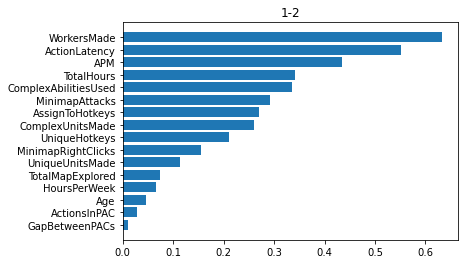

Optimization terminated successfully.
         Current function value: 0.590732
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            LeagueIndex   No. Observations:                  675
Model:                          Logit   Df Residuals:                      658
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.1128
Time:                        14:37:18   Log-Likelihood:                -398.74
converged:                       True   LL-Null:                       -449.45
Covariance Type:            nonrobust   LLR p-value:                 1.886e-14
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.1548      0.164      7.034      0.000       0.833       1.477

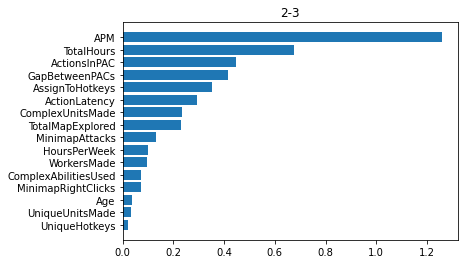

Optimization terminated successfully.
         Current function value: 0.616882
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            LeagueIndex   No. Observations:                 1023
Model:                          Logit   Df Residuals:                     1006
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                 0.08693
Time:                        14:37:18   Log-Likelihood:                -631.07
converged:                       True   LL-Null:                       -691.15
Covariance Type:            nonrobust   LLR p-value:                 5.101e-18
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6701      0.100      6.714      0.000       0.474       0.866

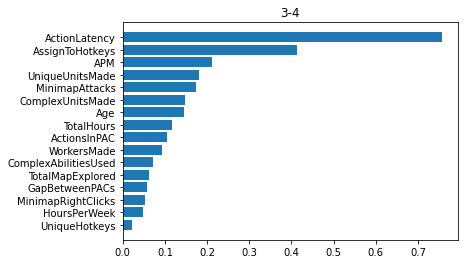

Optimization terminated successfully.
         Current function value: 0.592419
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            LeagueIndex   No. Observations:                 1210
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.1453
Time:                        14:37:18   Log-Likelihood:                -716.83
converged:                       True   LL-Null:                       -838.67
Covariance Type:            nonrobust   LLR p-value:                 1.021e-42
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3971      0.091     -4.387      0.000      -0.574      -0.220

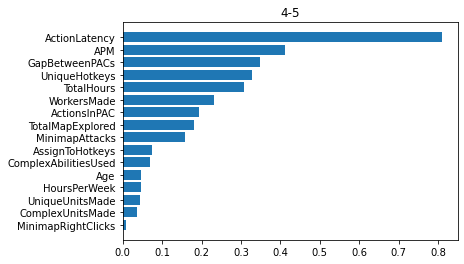

Optimization terminated successfully.
         Current function value: 0.592398
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            LeagueIndex   No. Observations:                 1068
Model:                          Logit   Df Residuals:                     1051
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.1343
Time:                        14:37:18   Log-Likelihood:                -632.68
converged:                       True   LL-Null:                       -730.81
Covariance Type:            nonrobust   LLR p-value:                 4.506e-33
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2217      0.122    -10.009      0.000      -1.461      -0.982

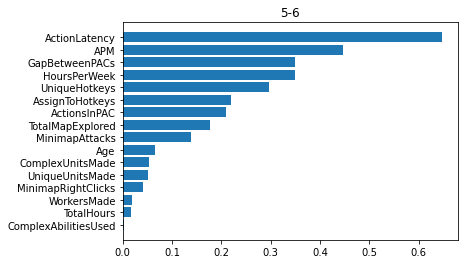

Optimization terminated successfully.
         Current function value: 0.118616
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            LeagueIndex   No. Observations:                  492
Model:                          Logit   Df Residuals:                      475
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.2746
Time:                        14:37:19   Log-Likelihood:                -58.359
converged:                       True   LL-Null:                       -80.455
Covariance Type:            nonrobust   LLR p-value:                 0.0001844
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.1781      0.923     -6.692      0.000      -7.988      -4.369

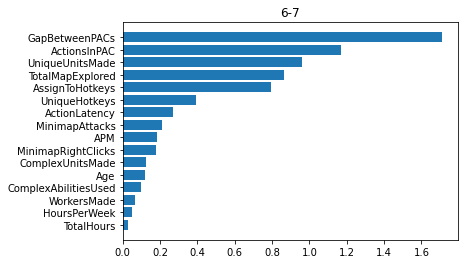

In [16]:
featImpPerTrans = []
featImpPairs = []
for trans in transNames:
    Xtest,ytest,logReg = logRegOnSplit(splitLeagues,trans)
    print(logReg.summary())
    sorted_idx = np.absolute(logReg.params.values[1:]).argsort()
    regNames = feat_sort(feat_names,np.absolute(logReg.params.values)[1:])
    featImpPerTrans.append(np.absolute(logReg.params.values[1:]).tolist())
    #print(len(np.absolute(logReg.params.values[1:])[sorted_idx]),len(regNames))
    plt.barh(regNames,np.absolute(logReg.params.values[1:])[sorted_idx])
    featImpPairs.append((regNames,np.absolute(logReg.params.values[1:])[sorted_idx].tolist()))
    plt.title(trans)
    plt.show()

0.9999999999999998
1.0000000000000002
1.0
1.0
1.0
1.0


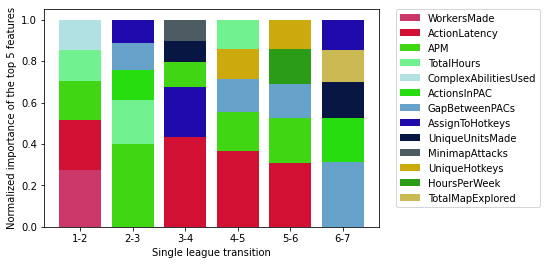

In [17]:
colorsDict={}
handle_list = []
label_list=[]
for num in range(16):
    colorsDict[feat_names[num]] = '#%06X' % randint(0, 0xFFFFFF)
for i in range(1,7):
    tempDF = pd.DataFrame(columns=['feature','data'])
    for y in range(15,10,-1):
        tempDF.loc[len(tempDF.index)] = [featImpPairs[i-1][0][y],featImpPairs[i-1][1][y]]
    tempDF['data'] = tempDF['data']/tempDF['data'].sum()
    print(tempDF['data'].sum())
    bottom = 0
    for row in tempDF.index:
        plt.bar(x=i,height=tempDF.iloc[row,1],bottom=bottom,label=tempDF.iloc[row,0],color=colorsDict[tempDF.iloc[row,0]])
        bottom += tempDF.iloc[row,1]
        handles, labels = plt.gca().get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)
    plt.legend(handle_list,label_list,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Single league transition')
plt.ylabel('Normalized importance of the top 5 features')
plt.xticks([1,2,3,4,5,6],['1-2','2-3','3-4','4-5','5-6','6-7'])
plt.show()

In [18]:
splitLeagues = LeagueSplit(starcraft,7)
featImpPerTrans = []
featImpPairs = []
for trans in transNames:
    Xtest,ytest,logReg = logRegOnSplit(splitLeagues,trans)
    print(logReg.summary())
    print('Unit Increase in transition '+trans+':')
    for coef,name in zip(logReg.params.values[1:],feat_names):
        print('A one unit increase of '+name+' will see a '+str(round(1-np.exp(coef),2))+' change in the odds ratio of increasing league by one.')
    

Optimization terminated successfully.
         Current function value: 0.545784
         Iterations 24
                           Logit Regression Results                           
Dep. Variable:            LeagueIndex   No. Observations:                  385
Model:                          Logit   Df Residuals:                      368
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.1341
Time:                        14:37:19   Log-Likelihood:                -210.13
converged:                       True   LL-Null:                       -242.68
Covariance Type:            nonrobust   LLR p-value:                 7.050e-08
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0400      1.250      0.832      0.405      -1.409       3.48

<ipython-input-18-a46a3a8f555f>:9: RuntimeWarning: overflow encountered in exp
  print('A one unit increase of '+name+' will see a '+str(round(1-np.exp(coef),2))+' change in the odds ratio of increasing league by one.')
<ipython-input-18-a46a3a8f555f>:9: RuntimeWarning: overflow encountered in exp
  print('A one unit increase of '+name+' will see a '+str(round(1-np.exp(coef),2))+' change in the odds ratio of increasing league by one.')
<ipython-input-18-a46a3a8f555f>:9: RuntimeWarning: overflow encountered in exp
  print('A one unit increase of '+name+' will see a '+str(round(1-np.exp(coef),2))+' change in the odds ratio of increasing league by one.')
<ipython-input-18-a46a3a8f555f>:9: RuntimeWarning: overflow encountered in exp
  print('A one unit increase of '+name+' will see a '+str(round(1-np.exp(coef),2))+' change in the odds ratio of increasing league by one.')
<ipython-input-18-a46a3a8f555f>:9: RuntimeWarning: overflow encountered in exp
  print('A one unit increase of '+name+' 